In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid

In [ ]:
!cp /content/drive/MyDrive/Duke-Interpolated.zip /content
!unzip -q Duke-Interpolated.zip

# Data

In [ ]:
folder_dirs = glob('/content/Duke-Interpolated/*')
len(folder_dirs)

68

In [ ]:
def shuffle_split(folder_dirs, val_pct=0.10, seed=99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int(len(folder_dirs) * val_pct)
    np.random.seed(seed)
    idx = np.random.permutation(len(folder_dirs))
    folder_dirs = np.array(folder_dirs)[idx]

    return folder_dirs[n_val:], folder_dirs[:n_val]

train_folders, valid_folders = shuffle_split(folder_dirs)
print(len(train_folders))
print(len(valid_folders))

62
6


In [ ]:
train_pre_dirs = []
for train_folder in train_folders:
    train_pre_dirs += glob(f'{train_folder}/pre*/*')

valid_pre_dirs = []
for valid_folder in valid_folders:
    valid_pre_dirs += glob(f'{valid_folder}/pre*/*')

print(len(train_pre_dirs))
print(len(valid_pre_dirs))

3968
384


In [ ]:
len('/content/Duke-Interpolated/Breast_MRI_001')

41

In [ ]:
/content/Duke-Interpolated/Breast_MRI_001/pre-dyn/TR=4.12,TE=1.36,SliceNo=1.jpg
/content/Duke-Interpolated/Breast_MRI_001/t1-tse/TR=600,TE=12,SliceNo=1.jpg

In [ ]:
class Pre2T1Dataset(Dataset):
    def __init__(self, pre_dirs, transform=None):
        self.pre_dirs = pre_dirs
        self.transform = transform

    def __len__(self):
        return len(self.pre_dirs)

    def __getitem__(self, index):
        pre_path = self.pre_dirs[index]
        endswith = pre_path.split('=')[-1]
        t1_path = glob(f'{pre_path[:41]}/t1-tse/*={endswith}')[0]

        pre_img = np.array(Image.open(pre_path).convert("L"))
        t1_img = np.array(Image.open(t1_path).convert("L"))

        if self.transform:
            augmentations = self.transform(image=pre_img, image0=t1_img)
            pre_img = augmentations["image"].float() / 255.0
            t1_img = augmentations["image0"].float() / 255.0

        return pre_img, t1_img

In [ ]:
trn_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
], additional_targets={'image0': 'image'})

val_tfms = A.Compose([
    ToTensorV2()
], additional_targets={'image0': 'image'})

In [ ]:
train_ds = Pre2T1Dataset(train_pre_dirs, trn_tfms)
valid_ds = Pre2T1Dataset(valid_pre_dirs, val_tfms)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(train_ds, batch_size=8, shuffle=False)

torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


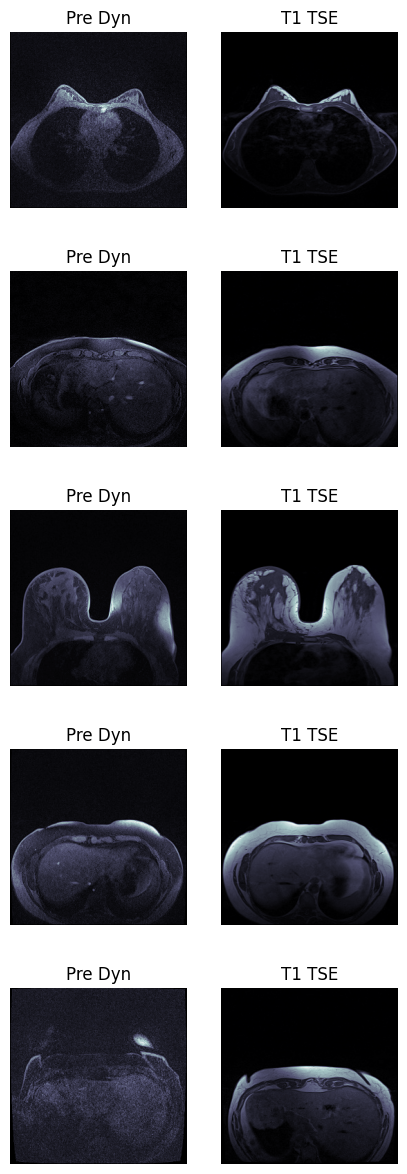

In [ ]:
pres, t1s = next(iter(train_dl))
print(pres.shape)
print(t1s.shape)

plt.figure(figsize=(5, 15))

for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(pres[i].permute(1, 2, 0), cmap='bone')
    plt.axis('off')
    plt.title('Pre Dyn')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(t1s[i].permute(1, 2, 0), cmap='bone')
    plt.axis('off')
    plt.title('T1 TSE')

# Model

In [ ]:
class Conv2D(nn.Module):
    """ conv + in + leaky """
    def __init__(self, in_channels, out_channels, stride):
        super(Conv2D, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
    """ 256x256 => 30x30 """
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Conv2D(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature

        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [ ]:
def test():
    x = torch.randn((1, 1, 256, 256))
    model = Discriminator(in_channels=1)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 1, 30, 30])


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super(Block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down==True
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            Block(channels, channels, kernel_size=3, padding=1),
            Block(channels, channels, kernel_size=3, padding=1, use_act=False),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels, features=64, num_residuals=9):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                Block(features * 1, features * 2, kernel_size=3, stride=2, padding=1),
                Block(features * 2, features * 4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                Block(features * 4, features * 2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                Block(features * 2, features * 1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(features * 1, in_channels, kernel_size=7, stride=1,padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [ ]:
def test():
    x = torch.randn((1, 1, 256, 256))
    gen = Generator(in_channels=1, features=9)
    print(gen(x).shape)

test()

torch.Size([1, 1, 256, 256])


# Training Functions

In [ ]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def train_discriminator(disc_P, disc_T, gen_P, gen_T, pre, t1, MSE, disc_opt):
    disc_P.train()
    disc_T.train()

    # T_reals = 0
    # T_fakes = 0
    fake_t1 = gen_T(pre)
    D_T_real = disc_T(t1)
    D_T_fake = disc_T(fake_t1.detach())
    # T_reals += D_T_real.mean().item()
    # T_fakes += D_T_fake.mean().item()
    D_T_real_loss = MSE(D_T_real, torch.ones_like(D_T_real))
    D_T_fake_loss = MSE(D_T_fake, torch.zeros_like(D_T_fake))
    D_T_loss = D_T_real_loss + D_T_fake_loss

    fake_pre = gen_P(t1)
    D_P_real = disc_P(pre)
    D_P_fake = disc_P(fake_pre.detach())
    D_P_real_loss = MSE(D_P_real, torch.ones_like(D_P_real))
    D_P_fake_loss = MSE(D_P_fake, torch.zeros_like(D_P_fake))
    D_P_loss = D_P_real_loss + D_P_fake_loss

    # put it togethor
    disc_loss = (D_P_loss + D_T_loss) / 2

    # Reset gradients
    disc_opt.zero_grad()

    # Compute gradients
    disc_loss.backward()

    # Adjust the parameters using backprop
    disc_opt.step()

    return fake_pre, fake_t1, disc_loss

In [ ]:
def train_generator(disc_P, disc_T, gen_P, gen_T, pre, t1, fake_pre, fake_t1, MSE, L1, gen_opt):
    gen_P.train()
    gen_T.train()

    # adversarial loss for both generators
    D_T_fake = disc_T(fake_t1)
    D_P_fake = disc_P(fake_pre)
    loss_G_T = MSE(D_T_fake, torch.ones_like(D_T_fake))
    loss_G_P = MSE(D_P_fake, torch.ones_like(D_P_fake))

    # cycle loss
    cycle_pre = gen_P(fake_t1)
    cycle_t1 = gen_T(fake_pre)
    cycle_pre_loss = L1(pre, cycle_pre)
    cycle_t1_loss = L1(t1, cycle_t1)

    # identity loss (remove these for efficiency if you set lambda_identity=0)
    # identity_pre = gen_P(pre)
    # identity_t1 = gen_T(t1)
    # identity_pre_loss = L1(pre, identity_pre)
    # identity_t1_loss = L1(t1, identity_t1)

    # add all togethor
    gen_loss = (
        loss_G_P
        + loss_G_T
        + cycle_pre_loss * 10
        + cycle_t1_loss * 10
        # + identity_t1_loss * 0
        # + identity_pre_loss * 0
    )

    # Backprop and optimize
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    return gen_loss

In [ ]:
def save_some_example(gen_P, gen_T, valid_dl, device, epoch, folder='evaluation'):
    if not os.path.exists(folder):
        os.makedirs(folder)

    pre, t1 = next(iter(valid_dl))
    batch_size = pre.shape[0]
    pre = pre.to(device)
    t1 = t1.to(device)

    gen_P.eval()
    gen_T.eval()

    with torch.no_grad():
        fake_t1 = gen_T(pre)
        fake_pre = gen_P(t1)
        fake_t1 = make_grid(fake_t1, nrow=4)
        fake_pre = make_grid(fake_pre, nrow=4)

        print('saving images...')
        save_image(fake_t1, folder + f'/fake_t1_{epoch}.jpg')
        save_image(fake_pre, folder + f'/fake_pre_{epoch}.jpg')

        if epoch == 1:
            pre = make_grid(pre, nrow = 4)
            t1 = make_grid(t1, nrow = 4)
            save_image(pre, folder + f'/pre_{epoch}.jpg')
            save_image(t1, folder + f'/t1_{epoch}.jpg')

In [ ]:
def fit(disc_P, disc_T, gen_P, gen_T, train_dl, valid_dl, MSE, L1, num_epochs, disc_opt, gen_opt, device, save_fn=None):

    d_losses, g_losses, val_acc, val_dice, val_iou = [], [], [], [], []
    total_step = len(train_dl)
    step = 0

    for epoch in range(num_epochs):
        for i, (pre, t1) in enumerate(train_dl):

            pre = pre.to(device)
            t1 = t1.to(device)

            # Train the descriminator and generator
            fake_pre, fake_t1, disc_loss = train_discriminator(disc_P, disc_T, gen_P, gen_T, pre, t1, MSE, disc_opt)
            gen_loss = train_generator(disc_P, disc_T, gen_P, gen_T, pre, t1, fake_pre, fake_t1, MSE, L1, gen_opt)

            # Inspect the losses
            if (i + 1) % 248 == 0:
                d_losses.append(disc_loss.item())
                g_losses.append(gen_loss.item())

                print('Epoch [{}/{}], Step [{}/{}], disc_loss: {:.4f}, gen_loss: {:.4f}'
                .format(epoch + 1, num_epochs, i + 1, total_step, disc_loss.item(), gen_loss.item()))

                step += 1

        # Save the model checkpoints
        save_checkpoint(disc_P, disc_opt, 'PreDis.pth')
        save_checkpoint(disc_T, disc_opt, 'T1Dis.pth')
        save_checkpoint(gen_P, gen_opt, 'PreGen.pth')
        save_checkpoint(gen_T, gen_opt, 'T1Gen.pth')

        # Sample and save images
        if save_fn is not None:
            save_fn(gen_P, gen_T, valid_dl, device, epoch + 1)

    return dict(disc_loss=d_losses, gen_loss=g_losses)

# Train

In [ ]:
# Hyper Function and Initializiation
seed_everything(seed=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

disc_P = Discriminator(in_channels=1).to(device)
disc_T = Discriminator(in_channels=1).to(device)

gen_P = Generator(in_channels=1, num_residuals=9).to(device)
gen_T = Generator(in_channels=1, num_residuals=9).to(device)

disc_opt = optim.Adam(list(disc_T.parameters()) + list(disc_P.parameters()), lr=2e-4, betas=(0.5, 0.999))
gen_opt = optim.Adam(list(gen_P.parameters()) + list(gen_T.parameters()), lr=2e-4, betas=(0.5, 0.999))

L1 = nn.L1Loss()
MSE = nn.MSELoss()

In [ ]:
history = fit(disc_P, disc_T, gen_P, gen_T, train_dl, valid_dl, MSE, L1, 50, disc_opt, gen_opt, device, save_some_example)

Epoch [1/50], Step [248/496], disc_loss: 0.2468, gen_loss: 2.4956
Epoch [1/50], Step [496/496], disc_loss: 0.3788, gen_loss: 2.1753
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
saving images...
Epoch [2/50], Step [248/496], disc_loss: 0.2715, gen_loss: 2.5261
Epoch [2/50], Step [496/496], disc_loss: 0.5038, gen_loss: 1.3744
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
saving images...
Epoch [3/50], Step [248/496], disc_loss: 0.4696, gen_loss: 1.3247
Epoch [3/50], Step [496/496], disc_loss: 0.4777, gen_loss: 1.2565
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
saving images...
Epoch [4/50], Step [248/496], disc_loss: 0.4679, gen_loss: 1.0863
Epoch [4/50], Step [496/496], disc_loss: 0.4732, gen_loss: 1.1723
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
saving images...
Epoch [5/50], Step [248/496], disc_loss: 0.4763, gen_loss: 1.0959
Ep

KeyboardInterrupt: ignored

In [ ]:
!cp /content/PreDis.pth /content/drive/MyDrive
!cp /content/T1Dis.pth /content/drive/MyDrive
!cp /content/PreGen.pth /content/drive/MyDrive
!cp /content/T1Gen.pth /content/drive/MyDrive

=> Loading checkpoint
=> Loading checkpoint


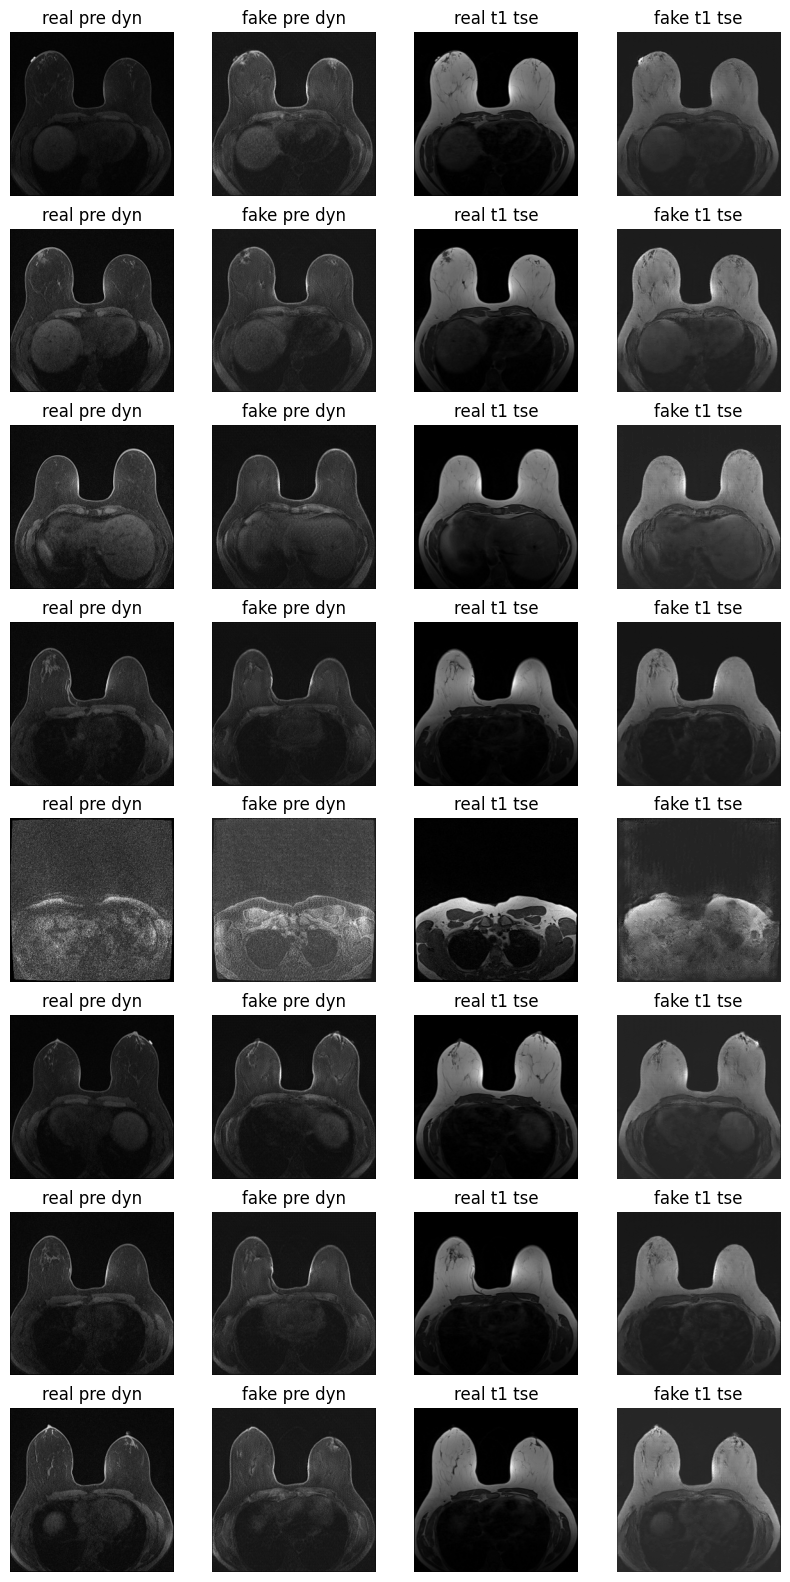

In [ ]:
load_checkpoint('/content/PreGen.pth', gen_P, gen_opt, lr=2e-4)
load_checkpoint('/content/T1Gen.pth', gen_T, gen_opt, lr=2e-4)
gen_P.eval()
gen_T.eval()


pre, t1 = next(iter(valid_dl))
pre = pre.to(device)
t1 = t1.to(device)

plt.figure(figsize=(10, 20))
with torch.no_grad():
    fake_t1 = gen_T(pre).detach()
    fake_pre = gen_P(t1).detach()
    for i in range(8):
        plt.subplot(8, 4, 4*i+1)
        plt.imshow(pre[i][0].cpu(), cmap='gray')
        plt.axis('off')
        plt.title('real pre dyn')
        plt.subplot(8, 4, 4*i+2)
        plt.imshow(fake_pre[i][0].cpu(), cmap='gray')
        plt.axis('off')
        plt.title('fake pre dyn')
        plt.subplot(8, 4, 4*i+3)
        plt.imshow(t1[i][0].cpu(), cmap='gray')
        plt.axis('off')
        plt.title('real t1 tse')
        plt.subplot(8, 4, 4*i+4)
        plt.imshow(fake_t1[i][0].cpu(), cmap='gray')
        plt.axis('off')
        plt.title('fake t1 tse')